In [97]:
import json, gzip, datetime, matplotlib.pyplot as plt, nltk, nltk.corpus, itertools
nltk.download('stopwords')
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Charlie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Posts within 24 hours and 10 miles radius

In [63]:
docsOR = [json.loads(line) for line in gzip.open('data/oregon-shooting.json.gz')]
docsPope = [json.loads(line) for line in gzip.open('data/pope-visit-dc.json.gz')]

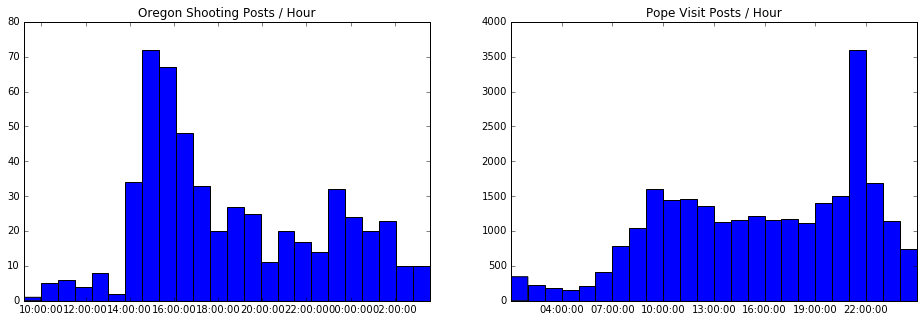

In [64]:
plt.figure(figsize=(16,5))
plt.subplot(121)
barsA = plt.hist([datetime.datetime.fromtimestamp(long(doc['timestamp_ms'])/1000.0) for doc in docsOR], bins=24)
titleA = plt.title('Oregon Shooting Posts / Hour')
plt.subplot(122)
barsB = plt.hist([datetime.datetime.fromtimestamp(long(doc['timestamp_ms'])/1000.0) for doc in docsPope], bins=24)
titleB = plt.title('Pope Visit Posts / Hour')

## A comparison of word freqencies in our training and test sets

In [92]:
docsTrain = [json.loads(line) for line in gzip.open('data/train.json.gz')]
stopwords = nltk.corpus.stopwords.words('english')
words = [w.lower() for w in itertools.chain(*[doc['text'].split() for doc in docsTrain]) if w.lower() not in stopwords]
fdist = nltk.FreqDist(words)
fdist.most_common(10)

[(u'#uccshooting', 26),
 (u"i'm", 24),
 (u'fox', 14),
 (u'producer', 12),
 (u'people', 12),
 (u'glad', 11),
 (u'please', 11),
 (u'everyone', 10),
 (u"can't", 10),
 (u'news.', 10)]

In [93]:
docsTest = [json.loads(line) for line in gzip.open('data/test.json.gz')]
words = [w.lower() for w in itertools.chain(*[doc['text'].split() for doc in docsTest]) if w.lower() not in stopwords]
fdist = nltk.FreqDist(words)
fdist.most_common(10)

[(u'#uccshooting', 33),
 (u"i'm", 30),
 (u'please', 26),
 (u'community', 20),
 (u'people', 19),
 (u'love', 17),
 (u'fox', 16),
 (u'go', 15),
 (u'producer', 15),
 (u'umpqua', 14)]

## A simple classifier based on word count

In [146]:
def relevance_features(doc):
    return {'word_count': len(doc['text'].split())}

# Load our training set and create a dictionary of the training posts
labeled_ids = json.load(open('data/train-set.json', 'r'))
docsTrainDict = {}
for doc in docsTrain: docsTrainDict[doc['id']] = doc

featuresets = [(relevance_features(docsTrainDict[doc_id]), relevance) for (doc_id, relevance) in labeled_ids]
train_set, test_set = featuresets[:100], featuresets[100:]
classifier = nltk.NaiveBayesClassifier.train(train_set)

In [147]:
classifier.classify(relevance_features({'text': 'Short post text'}))

u'unrelated'

In [151]:
[classifier.classify({'word_count': x}) for x in xrange(25)]

[u'unrelated',
 u'unrelated',
 u'unrelated',
 u'unrelated',
 u'unrelated',
 u'unrelated',
 u'unrelated',
 u'unrelated',
 u'unrelated',
 u'related',
 u'unrelated',
 u'unrelated',
 u'related',
 u'unrelated',
 u'unrelated',
 u'unrelated',
 u'unrelated',
 u'related',
 u'related',
 u'unrelated',
 u'unrelated',
 u'unrelated',
 u'related',
 u'related',
 u'related']

In [153]:
classifier.show_most_informative_features(10)

Most Informative Features
              word_count = 22             relate : unrela =      3.3 : 1.0
              word_count = 15             unrela : relate =      3.0 : 1.0
              word_count = 6              unrela : relate =      2.6 : 1.0
              word_count = 17             relate : unrela =      2.6 : 1.0
              word_count = 9              relate : unrela =      2.4 : 1.0
              word_count = 18             relate : unrela =      2.4 : 1.0
              word_count = 23             relate : unrela =      2.4 : 1.0
              word_count = 4              unrela : relate =      2.1 : 1.0
              word_count = 12             relate : unrela =      1.8 : 1.0
              word_count = 14             unrela : relate =      1.6 : 1.0


In [155]:
nltk.classify.accuracy(classifier, test_set)

0.65

## Stacking many classifiers

In [171]:
def relevance_features(doc):
    return {
        'word_count': len(doc['text'].split()),
        'has_hashtag': len(doc['entities']['hashtags']) > 0,
        'is_reply': bool(doc['in_reply_to_user_id']),
        'hour_posted': datetime.datetime.fromtimestamp(long(doc['timestamp_ms'])/1000.0).hour,
    }

featuresets = [(relevance_features(docsTrainDict[doc_id]), relevance) for (doc_id, relevance) in labeled_ids]
train_set, test_set = featuresets[:100], featuresets[100:]
classifier = nltk.NaiveBayesClassifier.train(train_set)

In [172]:
classifier.show_most_informative_features(10)

Most Informative Features
             has_hashtag = True           relate : unrela =      3.9 : 1.0
             hour_posted = 17             relate : unrela =      3.8 : 1.0
                is_reply = True           unrela : relate =      3.7 : 1.0
             hour_posted = 1              relate : unrela =      3.4 : 1.0
              word_count = 22             relate : unrela =      3.3 : 1.0
              word_count = 15             unrela : relate =      3.0 : 1.0
              word_count = 6              unrela : relate =      2.6 : 1.0
              word_count = 17             relate : unrela =      2.6 : 1.0
             hour_posted = 18             unrela : relate =      2.5 : 1.0
             hour_posted = 2              relate : unrela =      2.5 : 1.0


In [173]:
nltk.classify.accuracy(classifier, test_set)

0.77